In [10]:
from models import NormFlow
import torch
import torch.nn as nn
from tqdm.auto import tqdm

import os
import random
import numpy as np


import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [12]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=123)

In [13]:
class GMM():
    def __init__(self, locs, covariance_matrices):
        self.locs = torch.tensor([], device=locs[0].device)
        self.covariance_matrices = torch.tensor([], device=covariance_matrices[0].device)
        self.distributions = []
        self.device = locs[0].device
        for i in range(len(locs)):
            self.distributions.append(
                torch.distributions.MultivariateNormal(loc=locs[i], covariance_matrix=covariance_matrices[i]))

    def log_prob(self, z, x=None):
        log_p = torch.tensor([], device=z.device)
        for i in range(len(self.distributions)):
            log_paux = self.distributions[i].log_prob(z).view(-1, 1)
            log_p = torch.cat([log_p, log_paux], dim=-1)
        log_density = torch.logsumexp(log_p, dim=1)
        return log_density

    def sample(self, shape):
        p = np.random.choice(a=len(self.distributions), size=shape[0])
        samples = torch.tensor([], device=self.device)
        for idx in p:
            z = self.distributions[idx].sample((1,))
            samples = torch.cat([samples, z])
        return samples

In [14]:
dim = 2
loc = torch.zeros(dim, device=device, dtype=torch.float32)
loc[0] = 1.
loc_1 = loc * 3.
loc_2 = loc * -3.
covar = torch.eye(dim, device=device, dtype=torch.float32)
covar_1 = covar
covar_2 = covar
locs = [loc_1, loc_2]
covariance_matrices = [covar_1, covar_2]
target = GMM(locs, covariance_matrices)

In [15]:
prior = torch.distributions.Normal(loc=torch.tensor([0., 0.], device=device, dtype=torch.float32),
                                    scale=torch.tensor([1., 1.], device=device, dtype=torch.float32))

In [16]:
flow = NormFlow(flow_type="BNAF", num_flows=1, hidden_dim=2, need_permute=True).to(device)
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1500, gamma=0.5)

In [17]:
for idx in tqdm(range(500)):
    z = prior.sample((250, ))
    z_transformed, log_prob = flow(z)
    KL = torch.mean(prior.log_prob(z).sum(-1) - log_prob - target.log_prob(z_transformed))
    KL.backward()
    
    optimizer.step()
    optimizer.zero_grad()
    scheduler.step()
    
    if idx % 100 == 0:
        print(f"At epoch {idx} KL={KL.cpu().item()}")

At epoch 0 KL=4.451519966125488
At epoch 100 KL=0.3580264449119568
At epoch 200 KL=0.0498056523501873
At epoch 300 KL=-0.06168117746710777
At epoch 400 KL=-0.6236130595207214



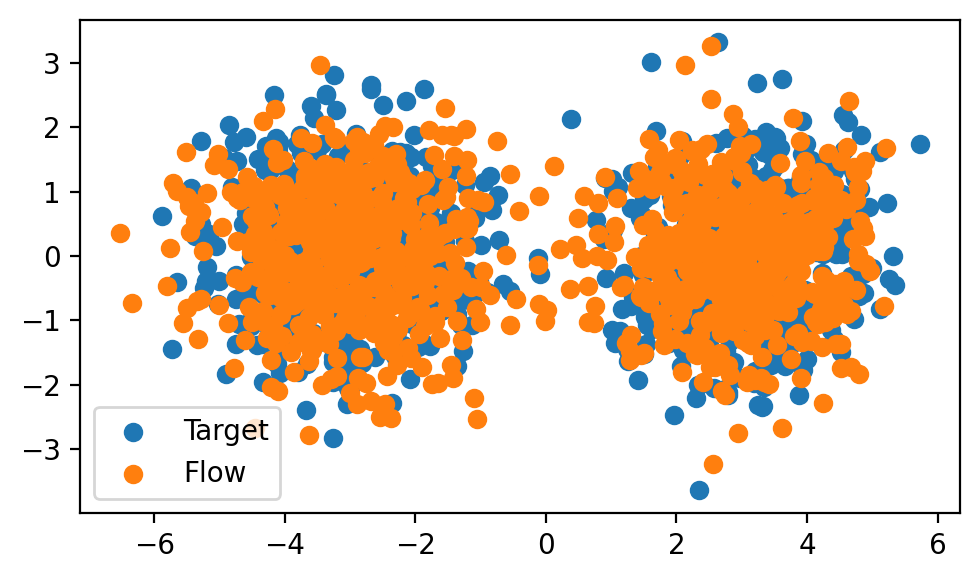

In [18]:
target_samples = target.sample((1000, )).cpu()
with torch.no_grad():
    z = prior.sample((1000, ))
    flow_samples = flow(z)[0].cpu()
    
    
plt.figure(dpi=200, figsize=(5, 3))
plt.scatter(target_samples[:, 0], target_samples[:, 1], label='Target')
plt.scatter(flow_samples[:, 0], flow_samples[:, 1], label='Flow')
plt.legend()
plt.tight_layout()
plt.show();